


## What kind of problem to solve?

Music Personalize Recommendation, here because of the target column is binary, we take this as a classification problem, in a nutshell, this is a binary classification.

In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys, numpy as np, pandas as pd, tensorflow as tf, re, codecs, json, time
import pickle, collections, random, math, numbers, scipy.sparse as sp, itertools, shutil
import requests, seaborn as sns

from collections import defaultdict, Counter
from datetime import datetime
from pprint import pprint
from matplotlib import pyplot as plt
# plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid') # 

ctx = os.path.abspath(os.path.dirname('.'))
if ctx not in sys.path:
    sys.path.insert(0, ctx)

from trainer import flex, utils, app_conf, metadata, input as inp, service
from trainer.ctrl import Ctrl

np.set_printoptions(precision=4, suppress=True, linewidth=100)
np.random.seed(42)

d:\python\anaconda3\envs\py3_6\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


init logger instance ...


## Preview
<br/>

### train.csv
Column | Description
--:--  | --:-- 
msno | user id
song_id | song id
source_system_tab | the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
source_screen_name | name of the layout a user sees.
source_type | an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.
target | this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .
<br/>

## songs.csv
Column | Description
--:--  | --:-- 
song_id | 
song_length | in ms
genre_ids | genre category. Some songs have multiple genres and they are separated by
artist_name | 
composer | 
lyricist | 
language |
<br/>

## members.csv
Column | Description
--:--  | --:-- 
msno | 
city | 
bd | age. Note: this column has outlier values, please use your judgement.
gender | 
registered_via | registration method
registration_init_time | format %Y%m%d
expiration_date | format %Y%m%d

## song_extra_info.csv
Column | Description
--:--  | --:-- 
song_id | 
song name | the name of the song.
isrc | International Standard Recording Code, theoretically can be used as an identity of a song. However, what worth to note is, ISRCs generated from providers have not been officially verified; therefore the information in ISRC, such as country code and reference year, can be misleading/incorrect. Multiple songs could share one ISRC since a single recording could be re-published several times.

In [2]:
utils.preview('./data/train.csv')

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [3]:
utils.preview('./data/test.csv')

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [4]:
utils.preview('./data/members.csv')

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [5]:
utils.preview('./data/songs.csv')

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [6]:
utils.preview('./data/song_extra_info.csv')

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


## Functions

In [2]:
def flat(multi_col):
    """Flat the splitted string multivariate feature with the target
        - catg1|catg2, 1
        - catg2|catg3, 0
               to
        -   catg1, 1
        -   catg2, 0
        -   catg2, 0
        -   catg3, 0
    """
    multi_list, target = [], []
    lens = data[multi_col].map(lambda e: len(e) if isinstance(e, tuple) else 1)
    data[multi_col].map(lambda e: multi_list.extend(e) if isinstance(e, tuple) else multi_list.append(None))
    pd.Series(list(zip(lens, data.target))).map(lambda tp: target.extend([tp[1]] * tp[0]))
    return multi_list, target

def univ_boxplot(df, colname):
    """Draw boxplot to observe the statistic values"""
    anchor_grp = df.groupby(colname)
    agg = pd.DataFrame({'mean': anchor_grp.target.mean().drop(''),
                        'sum': anchor_grp.target.sum().drop('')})
    agg['popular'] = agg['mean'] * agg['sum']
    plt.title(f'{colname} Popular Distribution')
    ax = sns.boxplot(x=agg.popular)
    plt.show()
    
def multi_catg_heatmap(multi_col, col):
    """Some features are category string, which contains maybe camma splitted,
     means multiple in a grid, called multivariate feature, so this function provide
     [univariate feature x multivariate feature] features heatmap with the mean of target
    """
    col_ary, multi_list_ary, target = [], [], []

    lens = data[multi_col].map(lambda e: len(e) if isinstance(e, tuple) else 1)
    data[multi_col].map(lambda e: multi_list_ary.extend(e) if isinstance(e, tuple) else multi_list_ary.append(None))
    pd.Series(list(zip(lens, data[col]))).map(lambda tp: col_ary.extend([tp[1]] * tp[0]))
    pd.Series(list(zip(lens, data.target))).map(lambda tp: target.extend([tp[1]] * tp[0]))

    df = pd.DataFrame({multi_col: multi_list_ary, col: col_ary, 'target': target})
    hm = df.groupby([multi_col, col]).target.mean().reset_index(name='target').pivot(multi_col, col, 'target').fillna(0)
    plt.figure(figsize=(10, 10))
    sns.heatmap(hm)
    plt.show()
    return hm

def heatmap(*cols, annot=True):
    f, axs = plt.subplots(1, 3, figsize=(20, 5))
    col1, col2 = cols[0], cols[1]
    grp = pd.DataFrame({col1: data[col1].values, col2: data[col2].values, 'target': data.target.values}).groupby(cols)
    
    pivot_params = list(cols) + ['target']
    g = data.groupby(cols).target
    mean_ = g.mean().reset_index().pivot(*pivot_params)
    count_ = g.size().reset_index().pivot(*pivot_params)
    sum_ = g.sum().reset_index().pivot(*pivot_params)
    
    sns.heatmap( mean_.fillna(0), annot=annot, ax=axs[0] )
    sns.heatmap( count_.fillna(0), annot=annot, ax=axs[1] )
    sns.heatmap( sum_.fillna(0), annot=annot, ax=axs[2] )
    axs[0].set_title('mean')
    axs[1].set_title('count')
    axs[2].set_title('sum')
    plt.show()

## Data Clean and Exploration


1. Drop `name` in `song_extra_info`

In [3]:
%%time
ori_data = pd.read_csv('./data/train.csv')
members = pd.read_csv('./data/members.csv')
songs = pd.read_csv('./data/songs.csv')
song_extra_info = pd.read_csv('./data/song_extra_info.csv')

Wall time: 23.3 s


In [4]:
ori_data = ori_data.merge(members, how='left', on='msno')\
               .merge(songs.merge(song_extra_info, how='left', on='song_id'),\
                      how='left', on='song_id')\
               .drop('name', 1)
        
del members, songs, song_extra_info

In [47]:
try: del data
except: pass
data = ori_data.copy()

init logger instance ...


In [48]:
%%time
enc_dict = {
    'song_id': utils.CounterEncoder(),
    'age': utils.CatgMapper(),
    'genre_list': utils.CounterEncoder(is_multi=True, sep='|'),
    'artist_list': utils.CounterEncoder(is_multi=True, sep='|'),
    'composer_list': utils.CounterEncoder(is_multi=True, sep='|'),
    'lyricist_list': utils.CounterEncoder(is_multi=True, sep='|'),
    'source_system_tab': utils.CatgMapper(),
    'source_screen_name': utils.CatgMapper(),
    'source_type': utils.CatgMapper(),
    'language':  utils.CatgMapper(),
    'city': utils.CatgMapper(),
    'cc': utils.CatgMapper(),
    'xxx': utils.CatgMapper(),
    'gender': utils.CatgMapper(),
    'registered_via': utils.CatgMapper()
}
date_fmt = '%Y%m%d'
columns = ['msno', 'song_id', 'source_system_tab', 'source_screen_name', 'source_type', 'city',
 'gender', 'registered_via', 'registration_init_time', 'expiration_date', 'song_length', 'genre_ids',
 'artist_name', 'composer', 'lyricist', 'language', 'isrc', 'cc', 'xxx', 'yy', 'target']
# Binning numeric feature age into categorical feature, 
# and take [age <= 0 or 81 <= age] as outlier
bins = np.array([6, 10, 20, 30, 40, 60, 80])
age_map = {0: 'outlier', 1: '6-10', 2: '10-20', 3: '20-30', 4: '30-40', 5: '40-60', 6: '60-80', 7: 'outlier'}
data['age'] = pd.Series(np.digitize(data.bd, bins)).map(age_map)
data['age'] = enc_dict['age'].fit_transform(data['age'])

Wall time: 1.47 s


In [62]:
enc = utils.CatgMapper(is_multi=True, sep='|')
enc.fit(data['genre_ids'])

CatgMapper(allow_null=True, default=None, is_multi=True, name=None, sep='|',
      vocabs=None, vocabs_path=None)

In [63]:
pd.Series.map

init logger instance ...


In [33]:
%%time
# Univariate
data['source_system_tab'] = enc_dict['source_system_tab'].fit_transform(data['source_system_tab'])
data['source_screen_name'] = enc_dict['source_screen_name'].fit_transform(data['source_screen_name'])
data['source_type'] = enc_dict['source_type'].fit_transform(data['source_type'])
data['language'] = enc_dict['language'].fit_transform(data['language'])
data['city'] = enc_dict['city'].fit_transform(data['city'])
data['gender'] = enc_dict['gender'].fit_transform(data['gender'])
data['registered_via'] = enc_dict['registered_via'].fit_transform(data['registered_via'])

# Multivariate
data['genre_list'] = enc_dict['genre_list'].fit_transform(data['genre_ids'])
data['artist_list'] = enc_dict['genre_list'].fit_transform(data['artist_name'])
data['composer_list'] = enc_dict['composer_list'].fit_transform(data['composer'])
data['lyricist_list'] = enc_dict['lyricist_list'].fit_transform(data['lyricist'])

Wall time: 6min 19s


In [34]:
%%time
# Decode isrc
data['cc'] = enc_dict['cc'].fit_transform(data.isrc.str.slice(0, 2))
data['xxx'] = enc_dict['cc'].fit_transform(data.isrc.str.slice(2, 5))

# Numeric
# Year diff from 2020
data['yy'] = data.isrc.str.slice(5, 7).fillna(-1).map(lambda e: 2000 + int(e) if e != -1 and int(e) < 18 else 1900 + int(e))
data.loc[data.yy == -1, 'yy'] = data.yy[data.yy != -1].median()
data['yy'] = 2020 - data.yy
data['registration_init_time'] = pd.to_datetime(data.registration_init_time, format=date_fmt).map(lambda e: e.timestamp() / 86400)
data['expiration_date'] = pd.to_datetime(data.expiration_date, format=date_fmt).map(lambda e: e.timestamp() / 86400)
data['tnr'] = data.expiration_date - data.registration_init_time

Wall time: 1min 35s


In [ ]:
%%time
data['song_id'] = 

In [35]:
data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,...,isrc,age,genre_list,artist_list,composer_list,lyricist_list,cc,xxx,yy,tnr
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,2,8,7,1,1,0,0,3,...,GBUM71602854,7,"(8,)","(859,)","(1829, 2109)",(),32,5764,4.0,2103.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,4,9,5,1,12,24,1,4,...,US3C69910183,2,"(6,)","(5,)",(),(),102,445,21.0,2301.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,4,9,5,1,12,24,1,4,...,USUM70618761,2,"(6,)","(2183,)","(38367,)",(),102,5764,14.0,2301.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,4,9,5,1,12,24,1,4,...,GBUQH1000063,2,"(114,)","(28685,)","(57777,)",(),32,5773,10.0,2301.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,2,8,7,1,1,0,0,3,...,QM3E21606003,7,"(16,)","(1697,)","(3004, 3114, 3144)",(),80,452,4.0,2103.0


In [131]:
print(data.columns.values)
data.head()

['msno' 'song_id' 'source_system_tab' 'source_screen_name' 'source_type' 'target' 'city' 'bd'
 'gender' 'registered_via' 'registration_init_time' 'expiration_date' 'song_length' 'genre_ids'
 'artist_name' 'composer' 'lyricist' 'language' 'isrc' 'cc' 'xxx' 'yy']


,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,...,song_length,genre_ids,artist_name,composer,lyricist,language,isrc,cc,xxx,yy
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,NaN,7,...,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,GBUM71602854,GB,UM7,2016
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,...,284584.0,1259,Various Artists,NaN,NaN,52.0,US3C69910183,US,3C6,1999
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,...,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,USUM70618761,US,UM7,2006
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24,female,9,...,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0,GBUQH1000063,GB,UQH,2010
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,0,NaN,7,...,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0,QM3E21606003,QM,3E2,2016


In [72]:
def map_msno(pipe):
    columns = []
    for col in ('source_system_tab', 'source_screen_name', 'source_type'):
        group = pipe.groupby(col)
        chop = group.target.agg(['sum', 'mean'])
        pref = chop['sum'] * chop['mean']
        
        cache = []
        tp = tuple(sorted(chop.index))
        for row in pipe.itertuples():
            weights = 
            cache.append([tp, weights])
            # pipe[f'{col}_multi'] = [tuple(sorted(chop.index.tolist()))] * len(pipe)
            # pipe[f'{col}_pref'] = pipe[col].map(lambda e: chop)
        columns += [col, f'{col}_multi', f'{col}_pref', f'{col}_freq']
        
    return pipe[['msno'] + columns]
    
data.head(1000).groupby('msno').apply(map_msno).reset_index(drop=True)

,msno,source_system_tab,source_system_tab_multi,source_system_tab_pref,source_system_tab_freq,source_screen_name,source_screen_name_multi,source_screen_name_pref,source_screen_name_freq,source_type,source_type_multi,source_type_pref,source_type_freq
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,explore,"(explore,)",4.00,4.0,Explore,"(Explore,)",4.00,4.0,online-playlist,"(online-playlist,)",4.00,4.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,my library,"(my library,)",4.00,4.0,Local playlist more,"(Local playlist more,)",4.00,4.0,local-playlist,"(local-playlist,)",4.00,4.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,my library,"(my library,)",4.00,4.0,Local playlist more,"(Local playlist more,)",4.00,4.0,local-playlist,"(local-playlist,)",4.00,4.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,my library,"(my library,)",4.00,4.0,Local playlist more,"(Local playlist more,)",4.00,4.0,local-playlist,"(local-playlist,)",4.00,4.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,explore,"(explore,)",4.00,4.0,Explore,"(Explore,)",4.00,4.0,online-playlist,"(online-playlist,)",4.00,4.0
5,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,explore,"(explore,)",4.00,4.0,Explore,"(Explore,)",4.00,4.0,online-playlist,"(online-playlist,)",4.00,4.0
6,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,my library,"(my library,)",4.00,4.0,Local playlist more,"(Local playlist more,)",4.00,4.0,local-playlist,"(local-playlist,)",4.00,4.0
7,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,explore,"(explore,)",4.00,4.0,Explore,"(Explore,)",4.00,4.0,online-playlist,"(online-playlist,)",4.00,4.0
8,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,my library,"(my library,)",4.00,4.0,Local playlist more,"(Local playlist more,)",4.00,4.0,local-library,"(local-library,)",4.00,4.0
9,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,my library,"(my library,)",4.00,4.0,Local playlist more,"(Local playlist more,)",4.00,4.0,local-library,"(local-library,)",4.00,4.0


In [79]:
a = pd.DataFrame({'a': [1, None, 2], 'b': [1, 1, 1]}).groupby('a')
for k, e in a:
    print(e)


     a  b
0  1.0  1
     a  b
2  2.0  1


In [26]:
def map_fn(pipe):
    return pipe[:int(len(pipe) * 0.7)]

data.groupby('msno').apply(map_fn).reset_index(drop=True).groupby('msno').size().describe()

count    29823.000000
mean       172.682527
std        221.267029
min          1.000000
25%         22.000000
50%         95.000000
75%        244.000000
max       4073.000000
dtype: float64

In [ ]:
enc = utils.CounterEncoder(is_multi=True, sep='|')
a = enc.fit_transform(data.genre_ids[:1000])
# data.genre_ids

init logger instance ...


In [67]:
def map_fn(pipe):
    pipe['genre_ids'] = tf.string_split([pipe['genre_ids']], delimiter='|').values
    return pipe

with tf.Graph().as_default():
    # ds = tf.data.Dataset.from_tensor_slices({'col1': [1, 2, 3], 'col2': [(1, 2), (0, 0), (0, 0)]})
    ds = tf.data.Dataset.from_tensor_slices(a.head(30)[['genre_ids', 'target']].to_dict('list'))
    ds = ds.map(map_fn)
    ds = ds.make_one_shot_iterator().get_next()
    # ds = tf.data.Dataset.from_generator(
    #     gen_fn, (tf.int32, tf.int32), (tf.TensorShape([None]), tf.TensorShape([]))
    # )
    with tf.Session() as sess:
        print( sess.run(ds) )
        pass

TypeError: Failed to convert object of type <class 'list'> to Tensor. Contents: ['359', '1259', '1259', '1019', '1011', '1259', '465', '1011', '2022', '465', '465', '465', '465', '458', '465|458', '465', '465', '458', '465', '465', '458', '465', '465', '2022', '2022', '2022', '465', '465', '465', nan]. Consider casting elements to a supported type.

In [40]:
df = pd.DataFrame({'composer_list': data.composer_list.dropna().values, 
                   'len': data.composer_list.dropna().map(len).values})
print(df.head())
df.loc[df.len.idxmax()].composer_list

                               composer_list  len
0                     (Dan Smith, Mark Crew)    2
1    (N. Jones、W. Adams、J. Lordan、D. Ingle,)    1
2                           (Kwadwo Donkoh,)    1
3  (Brett Young, Justin Ebach, Kelly Archer)    3
4                 (Adnan Khan, Sidney Selby)    2


('1011,Kenny Rogers,Roger Bowling',
 '139,G.E.M.鄧紫棋,Kaci Brown',
 '139,Oldies 101,William Mickey Stevenson',
 '947,Music-Themes,,,-1\nXPGjUo/wPuYRoFYVB25kQ9TX5zP6Izcllmez7PPXB4I=,241673,465,Janet Jackson,Janet Jackson',
 'Aaron Gillespie',
 'Brian Carroll,,52\n0KjXAae7rj9kfrIGhAoYBWJoQBqjtzTQMKMprbnStrs=,229506,,Monday Kiz,,,31\nvoMgKcLbhYr1GIsEuMvT+Rjkib1qvY4WPSmw/mc8j1c=,402703,940,Guy Sweens,,,-1\nPy+ROjXqGeJtSyQu1GWUEdvOkbEoKmBowX9lCq+E1Ow=,203593,1259,Pigeon John,,,52\n8jxho4ldBqaadnEiNjhgF8keOFBc4z6Gy6zTMKvw7Tg=,245856,465,Bertie Higgins,Bertie Higgins/Sonny Limbo,Bertie Higgins/Sonny Limbo,52\nImz3KL8KDLWIvNu/ytrFODhUvNCfziDLNdQP3OBIH/c=,347834,726,Hillsong Kids Junior,,,-1\nmRh2QjHNk3tcjKszLXpnCWUgREMRk6H4RDOdCn48T8w=,249568,465,Melanie C,Rick Nowels',
 'Charles Twong',
 'Chauncey Hollis,,52\n9sYIx+29PAF7BOk4loE2xYPSdeg7zmpGwbbInOyVhVo=,172849,921,Randy Newman,Axwell',
 'Christopher Dudley,,52\nOi7rlCO6VbZZ5UqcSyg8vDVvFjMQYeV+iYAbxB6LSd0=,169227,2122,Sarah Vaughan,R. Turk',
 'D

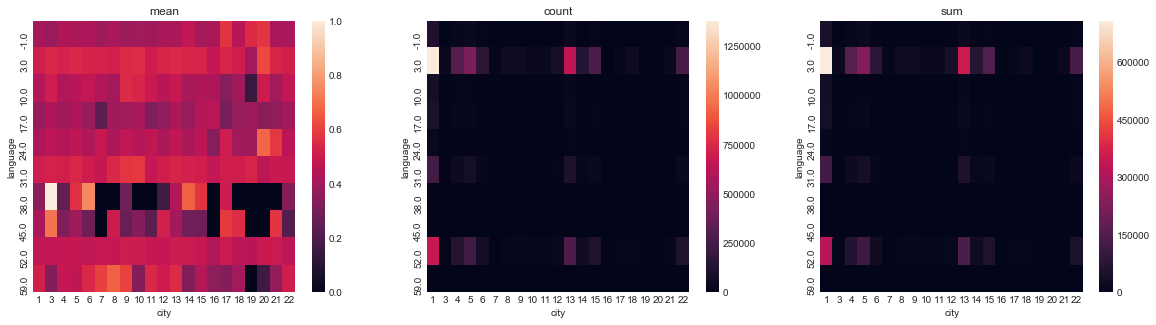

In [41]:
heatmap('language', 'city', annot=False)

## Age and Genres

In [ ]:
%%time
multi_catg_heatmap('genre_list', 'age')

## Popular Artist
-  We evaluate the popularity of the artist by calculate `mean * sum` by target label, value of target belong to [0, 1], so `sum` can represent the popularity but, maybe there are many 0 in the votes, so multiple the `mean` to get more fair result
-  According the boxplot, the popularity distribution is very skew, most of them close to zero, this is expected result, for this situation, we will add some features like the interaction between `[target + artist], [target + language]`..., etc.

In [ ]:
artist_list, target = flat('artist_list')
univ_boxplot(pd.DataFrame({'artist_list': artist_list, 'target': target}), 'artist_list')

In [ ]:
artist_list, target = flat('artist_list')
univ_boxplot(pd.DataFrame({'artist_list': artist_list, 'target': target}), 'artist_list')

<br/>
<br/>
<br/>
## Filter some rows

1. First we filter out the majority and the minority => [100 <= msno.group.size <= 1000], we don't want some majority to dominate the model
2. Insure that records of target = 1 greater than 35, we want 30% in valid data records of target = 1 greater than 10
    ```
    35 * 0.3 = 10.5
    ```

In [ ]:
""" Use DataFrameGroupBy.filter will be greate !!!"""
# msno_grp = data.groupby('msno')
# msno_grp.size().describe()

# df = pd.DataFrame({'size': msno_grp.size(), 'sum': msno_grp.target.sum()})

# data = data[data.msno.isin(df.query('sum >= 35 and 100 <= size and size <= 1000').index)]
# print(data.shape)
# print(data.target.value_counts())

In [ ]:
enc = utils.CounterEncoder()
enc.partial_fit( train.source_system_tab )

In [ ]:
np.linalg.norm([1, 2, 3] / np.linalg.norm([1, 2, 3]))


In [ ]:
feat = 'source_system_tab'
feat_dummies = pd.get_dummies(data[feat])
feat_dummies.columns = ['msno_%s_'%feat + '%s'%col for col in feat_dummies.columns]
feat_dummies.head()
feat_dummies['msno'] = data['msno'].values
feat_dummies = feat_dummies.groupby('msno').mean()
feat_dummies['msno'] = feat_dummies.index
a = members.merge(feat_dummies, on='msno', how='left')
a.head()

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
## Univariate Analysis
- Observe some categorical variables, see if there is some sigificant relation
- In this section:
    - Significant:
        - `Promo`: the sales raise in promo perieod.
        - `DayOfWeek`: When DayOfWeek = 7, it obviously people count less than average
        - `StoreType`: StoreType = 'b' has the lowest counts and the highest average
    - Not significant:
        - `Promo2`: Nothing found!

## Target Column: Sales
1. Observe the the describe table and boxplot of target, the mean is about 5773, so we need to take logrithm in order to reduce scale

In [ ]:
df = pd.DataFrame({'Sales': tr_merge.Sales.tolist() + np.log1p(tr_merge.Sales).tolist(), 
                   'clazz': ['Origin'] * len(tr_merge) + ['After np.log1p'] * len(tr_merge)})
print(df.query("clazz == 'Origin'").Sales.describe())
print()
print(df.query("clazz == 'After np.log1p'").Sales.describe())
sns.factorplot(x='clazz', y='Sales', data=df, kind="box", size=4, aspect=2, sharey=False)
plt.show()

## Promo

In [ ]:
# plt.figure(figsize=(12, 6))
print(tr_merge.groupby('Promo').Sales.sum())
g = sns.FacetGrid(tr_merge, row='Open', col='Promo', size=2, aspect=2)
g = g.map(plt.hist, "Sales").add_legend()

sns.factorplot(x="Promo", y="Sales", data=tr_merge, kind="box", size=4, aspect=2)

In [ ]:
agg = tr_merge.groupby(['Promo']).Sales.describe()
agg['sum'] = agg['count'] * agg['mean']
agg

## Promo2

In [ ]:
# plt.figure(figsize=(12, 6))
print(tr_merge.groupby('promo2').Sales.sum())
g = sns.FacetGrid(tr_merge, row='Open', col='promo2', size=2, aspect=2)
g = g.map(plt.hist, "Sales").add_legend()

sns.factorplot(x="promo2", y="Sales", data=tr_merge, kind="box", size=4, aspect=2)

In [ ]:
agg = tr_merge.groupby(['promo2']).Sales.describe()
agg['sum'] = agg['count'] * agg['mean']
agg

### DayOfWeek

In [ ]:
# plt.figure(figsize=(12, 6))
g = sns.FacetGrid(tr_merge, col='DayOfWeek', sharey=True, size=3, aspect=1)
g = g.map(plt.hist, "Sales")

sns.factorplot(x="DayOfWeek", y="Sales", data=tr_merge, kind="box", size=4, aspect=3)

In [ ]:
agg = tr_merge.groupby('DayOfWeek').Sales.describe()
agg['sum'] = agg['count'] * agg['mean']
agg

## StoreType

In [ ]:
g = sns.FacetGrid(tr_merge, col='StoreType', sharey=True, size=3, aspect=1)
g = g.map(plt.hist, "Sales")

sns.factorplot(x="StoreType", y="Sales", data=tr_merge, kind="box", size=4, aspect=3)

In [ ]:
agg = tr_merge.groupby('StoreType').Sales.describe()
agg['sum'] = agg['count'] * agg['mean']
agg

<br/>
<br/>
<br/>
<br/>
<br/>
## Bivariate Analysis
- In this section:
    - Significant:
        - `Promo + StateHoliday`: In mean heatmap figure, there is a peak on StateHoliday = 'b'
        - `State + StoreType`: When StoreType = 'b', the average of sales are unstable, and many States don't have StoreType 'b'
        
    - Not significant:
        - `Promo + SchoolHoliday`: Just found sum of the records with SchoolHoliday = 1 are less
        - `month + day`: In count heatmap, obviously records count(customers count) before july are upper than average, but we founds many store loss records in late date of timeline, that's why
        - `year + month`: Some peak in mean heatmap in December, corresponding to mean heatmap of [month + day], not really significant

In [ ]:
def heatmap(*cols, annot=True):
    # cols = ['Promo', 'SchoolHoliday']
    pivot_params = list(cols) + ['Sales']
    g = tr_merge.groupby(cols).Sales
    mean_ = g.mean().reset_index().pivot(*pivot_params)
    count_ = g.size().reset_index().pivot(*pivot_params)
    sum_ = g.sum().reset_index().pivot(*pivot_params)

    f, axs = plt.subplots(1, 3, figsize=(16, 4))
    sns.heatmap(mean_, annot=annot, ax=axs[0])
    sns.heatmap(count_, annot=annot, ax=axs[1])
    sns.heatmap(sum_, annot=annot, ax=axs[2])
    axs[0].set_title(f'mean')
    axs[1].set_title(f'count')
    axs[2].set_title(f'sum')
    plt.show()

### Promo, SchoolHoliday 

In [ ]:
# print(tr_merge.groupby(['Store', 'SchoolHoliday', 'Promo']).Sales.sum())
g = sns.FacetGrid(tr_merge, row='SchoolHoliday', col='Promo', size=2, aspect=2)
g = g.map(plt.hist, "Sales").add_legend()

sns.factorplot(x="Promo", y="Sales", col='SchoolHoliday', data=tr_merge, kind="box", size=3, aspect=2)

heatmap('Promo', 'SchoolHoliday')

### Promo, StateHoliday 

In [ ]:
# g = sns.FacetGrid(tr_merge, row='StateHoliday', col='Promo', size=2, aspect=2)
# g = g.map(plt.hist, "Sales").add_legend()

sns.factorplot(x="Promo", y="Sales", col='StateHoliday', data=tr_merge, kind="box", size=3, aspect=2)

heatmap('Promo', 'StateHoliday')

### State, StoreType

In [ ]:
# g = sns.FacetGrid(tr_merge, col='State', row='StoreType', sharey=True, size=4, aspect=.5)
# g = g.map(plt.hist, "Sales")

sns.factorplot(x="State", y="Sales", row='StoreType', data=tr_merge, kind="box", size=4, aspect=3)

heatmap('State', 'StoreType', annot=False)

In [ ]:
# sns.factorplot(x="day", y="Sales", row='month', data=tr_merge, kind="box", size=4, aspect=3)
heatmap('month', 'day', annot=False)

<br/>
<br/>
<br/>
## Recall The Exploration
There are many combination of columns we didn't see, to view all the combination is not efficient, that's why we use embedding to encode the categorical variables, in Tensorflow, `tf.feature_columns.crossed_column` can help us to make machine learn the information hidden in data, or handle all the combination by yourself, but imagine that we couldn't expect all the crossed combination happend in training data, if some outlier happened in serving time, the performance usually bad as expected.
<br/><br/>
Fortunately, without using crossed features we still got good performance, and we drop `year` columns as the same reason we mentioned, future year not show in training data result in the bad performance happended (Remember we treat year as categorical variable), month and day features  show periodically

## Module structure
    ```
    └─trainer
        │  app_conf.py
        │  ctrl.py
        │  input.py
        │  logging.yaml
        │  metadata.py
        │  model.py
        │  service.py
        └─ utils.py        
    ```
    Directory trainer contains all modules: 
    
|File Name| Purpose| Do You Need to Change?
|:---|:---|:---
|[app_conf.py](trainer/app_conf.py) | Applicaiton configures, tell where are the training data, the model checkpoint directory, and hyperparameter | **Yes**, any params you don't want to pass in ctrl.py, you can put them here, but still, like the path to train directory, it's suggested to put app_conf.py instead of pass on the fly to controller.
|[ctrl.py](trainer/ctrl.py) |The entrance of the program, accept any parameters, protable for local terminal or restful style environment. | **Maybe**, althought the processing is constructed, some of detail you might wont to modify.
|[service.py](trainer/service.py) |The business logic module behind the controller(ctrl.py) | **Yes**, usually you still have your own programe process
|[utils.py](trainer/service.py) | Utility module, some common function to put here, like logging function. | **Yes**, maybe you will have some special utils function to implement.
|[metadata.py](trainer/metadata.py)|Defines: 1) task type, 2) input data header, 3) numeric and categorical feature names, 4) target feature name (and labels, for a classification task), and 5) unused feature names. | **Yes**, as you will need to specify the metadata of your dataset. **This might be the only module to change!**
|[input.py](trainer/input.py)| Includes: 1) data input functions to read data from csv and tfrecords files, 2) parsing functions to convert csv and tf.example to tensors, 3) function to implement your features custom  processing and creation functionality, and 4) prediction functions (for serving the model) that accepts CSV, JSON, and tf.example instances. | **Maybe**, if you want to implement any custom pre-processing and feature creation during reading data.
|[model.py](trainer/model.py)|Includes: 1) function to create DNNRegressor, 2) function to implement for a custom estimator model_fn. 3) include **Feature class** to assign the feature spec, the feature spec usually bind for specific model, so we put them together. | **Yes**, in **Model.get_estimator** Usually, at least you want to modify the hidden_units params.

<br/>
<br/>
<br/>
## Data preprocessing
1. Data offered like this
    ```
    │  store.csv
    │  store_states.csv
    │  test.csv
    └─ train.csv
    ```
2. Data pipeline on training period we propose 4 steps: **prepare -> fit -> transform -> split**
    - Prepare: 
        - Join store and store_states to make the **Fat table**
        - Add features we mentioned in data exploration, drop also.
        - Filter some records not appropriate, like open = 0
        - Maybe persistent some files
    - Fit: 
        - Persistent the statistical information of numeric features
        - Persistent the unique count value of categorical features
    - Transform:
        - Normalization, logarithm ... etc.
        - Make all categorical variable to int, one hot encoding ... etc.
        - Take logarithm of the target column
    - Split:
        - Do split logic, in this case we order by date, and take 0.3 as valid data size, train data is first 0.7 part, and rest is valid data
        
3. Data pipeline on serving period just 2 steps: **prepare -> transform**
    - Prepare: As prepare step in training period, just some detail different, like not filter open = 0 here
    - Transform: Same as transform step in training period, usually delete the target column
    
4. There is something weird is feature `Customers` is not in the test.csv, at heatmap of pearson corr we know that this feature got linear relation with the target column, but pity is we have to drop the column.

In [ ]:
%%time
from trainer import app_conf, input, metadata
from trainer.ctrl import Ctrl

Ctrl.instance.prepare(app_conf.instance)

<br/>
<br/>
<br/>
## Model Structure

The model mainly use tf.esimator.DNNRegressor
- Loss function: mean squre error, default fixed by `tf.estimator.DNNRegressor` 
- DNN Structure: `81 -> 1000 -> 500 -> 1`, 81 is the dimension of concatenate all features, the last output dimension must set to 1 because of the prediction target is float.
- No dropout: check the train section, we use best checkpoint picker to avoid overfitting.
- ReLU activation function at each layer
<br/><br/>

## Train
- Training for 3 epochs, use `tf.estimator.DNNRegressor`
- Use `tf.train.GradientDescent` Optimizer with learning rate `0.0001`
- Batch size = 256
- Best exporter: we do evaluation on every train epoch end, the export condition is better than last evaluation(lower loss or higher accuracy),
we don't export the worse result.
- When validation time, we observe the `MAE(Mean Absolute Error)` and `RMSE(Root Mean Square Error)` error metrics

In [ ]:
%%time
from trainer import app_conf, metadata, input as inp, service
from trainer.ctrl import Ctrl

ctrl = Ctrl.instance
ctrl.train(None)

### Model Performance(TensorBoard Screen Shot): RMSE on Valid Data: 0.19
![Pic from tensrorboard](model_metric.jpg)

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

## Protocol buffer file inspection
- Use saved_model_cli to inspect the protocol buff schema

In [ ]:
export_dir = utils.find_latest_expdir(app_conf.instance)
print( utils.cmd(f'saved_model_cli show --dir {export_dir}') )

In [ ]:
export_dir = utils.find_latest_expdir(app_conf.instance)
print( utils.cmd(f'saved_model_cli show --dir {export_dir} --tag_set serve') )

In [ ]:
export_dir = utils.find_latest_expdir(app_conf.instance)
command = f'saved_model_cli show --dir {export_dir} --tag_set serve --signature_def predict'
print( utils.cmd(command) )

## Local prediction
1. Transform raw input data for prediction
2. Local prediction
    - call ctrl.local_predict: simply use `tensorflow.contrib.predictor`
        ```python
        from tensorflow.contrib import predictor
        predict_fn = predictor.from_saved_model(export_dir, signature_def_key='predict')
        pred = predict_fn( ... )
        ```
3. Online prediciton
    - deploy model to ml-engine
        1. Create model reository(resource)
        2. Add version in model container, in this example we clean the reository first (delete all old version)
        3. Determine the **default version**, default is the latest version
    - call ctrl.online_predict
    
4. In this case, we need to take np.expm1 to the predict result

In [ ]:
%%time
from trainer import app_conf, metadata, input, service
from trainer.ctrl import Ctrl

ctrl = Ctrl.instance
test_df = ctrl.transform(pd.Series({'fpath': './data/test.csv'}))
params = pd.Series({
    'datasource': test_df,
    'is_src_file': False
})
pred = Ctrl.instance.local_predict(params)
print(pred)

## Deply to ml-engine

- Set environ variable to read the api key json file: 
    - In trainer/app_conf.py, `Config.api_key_path` set the API key json path to acquire the access to any GCP service

In [ ]:
%%time
from oauth2client.client import GoogleCredentials
from trainer import app_conf, metadata, input, service
from trainer.ctrl import Ctrl
ctrl = Ctrl.instance

ctrl.set_client_secret()

- Upload saved pb file to GCS

In [ ]:
%%time
ctrl = Ctrl.instance
p = pd.Series({
    'bucket_name': 'ml-specialized',
    'model_path': utils.find_latest_expdir(app_conf.instance),
    'prefix': 'models/rossmann'
})
ctrl.upload_model(p)

#### Deploy
- Create model resource and version
- Call deploy api

In [ ]:
ctrl = Ctrl.instance
p = pd.Series({
    'model_name': 'ml_specilized_rossmann',
    'deployment_uri': 'gs://ml-specialized/models/rossmann'
})
ctrl.deploy(p)

- Call deployed model

Because of the traffic volume limitation, just show first 100 rows online prediction

In [ ]:
test_df = Ctrl.instance.transform(pd.Series({'fpath': './data/test.csv'}))
p = pd.Series({
    'model_name': 'ml_specilized_rossmann',
    'datasource': test_df[:100].to_dict('records')
})
result = Ctrl.instance.online_predict(p)
result

<br/>
<br/>
<br/>
<br/>
<br/>
## Check predictions
---
Plot timeline in each store sales, prev 70% are training data and post 30% are validation data, predict valid data and compare to the ground truth

In [ ]:
tr = pd.read_csv('./data/processed/train_pr.csv').query('open == 1')
vl = pd.read_csv('./data/processed/valid_pr.csv').query('open == 1')
# Add date column for time series inspection
tr['date'] = pd.read_json(app_conf.instance.tr_dt_file, typ='series').values
vl['date'] = pd.read_json(app_conf.instance.vl_dt_file, typ='series').values

tr['predict'] = np.nan
params = pd.Series({
    'datasource': vl.drop(['sales', 'date'], 1),
    'is_src_file': False
})
vl['predict'] = Ctrl.instance.local_predict(params)

merge = pd.concat([tr, vl], 0)
merge['sales'] = np.expm1(merge.sales)
merge.head()

- Modify the `pos` variable to controll the start position, the following plot will show 3 figures a time

In [ ]:
pos = 100

In [ ]:
n_rows, n_cols = 3, 1
f, ax = plt.subplots(n_rows, n_cols, figsize=(20, 8), sharex=True, sharey=True)
for r, idx in enumerate(np.arange(pos, pos + n_rows)):
    samples = merge.query(f'store == {idx}').sort_values('date')
    hist = samples.query('predict.isnull()')
    predict = samples.query('predict.notnull()')
    ax[r].plot(np.arange(len(hist)), hist.sales.values, c='gray', label='history')
    ax[r].plot(np.arange(len(hist), len(hist) + len(predict)), predict.sales.values, label='actual')
    ax[r].plot(np.arange(len(hist), len(hist) + len(predict)), predict.predict.values, label='predict')
    ax[r].set_title(f'{idx}', size=18)
    ax[r].grid(True)
    ax[r].legend(loc='best', prop={'size': 16})
pos += n_rows
plt.show()

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
## Appendix

+ Use `tf.saved_model.loader.load`, only for `json_serving_input_fn `

In [ ]:
%%time
from trainer import app_conf, metadata, input, service
from trainer.ctrl import Ctrl

ctrl = Ctrl.instance
test_df = ctrl.transform(pd.Series({'fpath': './data/test.csv'}))
params = pd.Series({
    'datasource': test_df,
    'is_src_file': False
})
pred = ctrl.local_predict_alt(params)
print(pred)

## Tensor data inspection

In [ ]:
%%time
from trainer import app_conf, metadata, input, service
from trainer.ctrl import Ctrl

encoded, origin, feat_data, target_, all_ = Ctrl.instance.inspect('promo2')

In [ ]:
all_.shape

## Test

In [ ]:
%%time
from trainer import app_conf, metadata, input, service
from trainer.ctrl import Ctrl

ctrl = Ctrl.instance
serv_inp = ctrl.test()
pprint(serv_inp.receiver_tensors)
print()
pprint(serv_inp.features)